In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dill
import pandas as pd
import os, sys
sys.path.append('../')
import mg_si
%matplotlib inline
from matplotlib import gridspec


In [2]:
def change_in_core_wt(pl,t,solution):
    wt0 = np.sum(pl.reactions.core.M2wt(solution[0,2:6]))
    wte = np.sum(pl.reactions.core.M2wt(solution[-1,2:6]))
    return (wte-wt0)/wt0
    

In [3]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
def smooth(x,N=3):
    assert(N%2==1)
    out = np.array(x)
    out[(N-1)//2:-(N-1)//2] = running_mean(x,N)
    return out
def replace_outliers(y, percent=0.2, N=5):
    assert(N%2==1)
    Nends = N-1
    outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(Nends*y[Nends//2:-Nends//2])-1) > percent)[0]+1
    y2 = np.array(y)
    y2[outliers] = 0.
    for n in range(1,Nends//2+1):
        y2[outliers] += (y[outliers-n]+y[outliers+n])/Nends
    return y2
def remove_outliers(t,y,percent=0.3, N=3):
    Nends = N-1
    yo = y + np.mean(y)*.1
#     non_outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(Nends*y[Nends//2:-Nends//2])-1) < percent)[0]+Nends//2
    non_outliers = np.where( np.abs((yo[:-Nends]+yo[Nends:])/(2*yo[Nends//2:-Nends//2]) - 1) < percent)[0]+Nends//2
    return t[non_outliers], y[non_outliers]

def get_all_wtp(basedir, csvfile, solutionfile):
    column_names = ['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn']
    df = pd.read_csv(basedir+csvfile, names=column_names)
    N = len(df)
    all_wtp = np.zeros((df.shape[0],4))
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        all_wtp[i,:] = pl.reactions.core.M2wtp(solution[-1,2:6])
    return all_wtp

def load_all_data_nature(basedir, csvfile, alldatafile='all_parameters.m'):
    all_data = []
    column_names = ['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn']
    df = pd.read_csv(basedir+csvfile, names=column_names)
    N = len(df)
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+alldatafile):
            continue
        t_N, allp = dill.load(open(basedir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        all_data.append((t_N, allp, foldername))
    return all_data

# Find plots with all three exsolution over time

In [4]:
csvfile = 'ri10p_data.csv'
# csvfile = 'ri05p_data.csv'
# csvfile = 'ri05p_l6000K_data.csv'

alldatafile = 'all_parameters.m'
basedir = '/media/nknezek/compute_storage/computed_solutions_nature/'
solutionfile = 'data.m'
all_ents = load_all_data_nature(basedir, csvfile, alldatafile=alldatafile)

In [5]:
## Find a good one showing exsolution

for (pl,dat,fn) in all_ents:
    dat.Egf_total = np.sum(dat.Egf)
    dat.Egm_total = np.sum(dat.Egm)
    dat.Egs_total = np.sum(dat.Egs)
    dat.Eex_total = np.sum(dat.Eex)
    dat.Es_total = np.sum(dat.Es)
    fr = dat.Egf_total/dat.Eex_total
    mr = dat.Egm_total/dat.Eex_total
    sr = dat.Egs_total/dat.Eex_total
    try:
        indf = np.where(dat.Egf>1e6)[0][0]
        indm = np.where(dat.Egm>1e6)[0][0]
        inds = np.where(dat.Egs>1e6)[0][0]
        dimf = np.abs(indf-indm)
        dims = np.abs(indm-inds)
        cut = .1
        dcut = 50
        if fr>cut and mr>cut and sr>cut and indm>100 and inds>100 and dimf>dcut and dims>dcut and dat.Eex_total>dat.Es_total:
            print(fn, indf, indm, inds)
    except:
        pass

Tc5700.0_XM0.010_XS0.050_XO0.050/ 6 183 307
Tc5700.0_XM0.010_XS0.050_XO0.060/ 5 124 212
Tc5700.0_XM0.010_XS0.060_XO0.050/ 6 168 298
Tc5700.0_XM0.010_XS0.060_XO0.060/ 4 108 209
Tc5700.0_XM0.010_XS0.070_XO0.050/ 6 156 294
Tc5700.0_XM0.010_XS0.080_XO0.050/ 5 144 295
Tc5800.0_XM0.010_XS0.050_XO0.050/ 7 209 342
Tc5800.0_XM0.010_XS0.060_XO0.050/ 6 196 341
Tc5800.0_XM0.010_XS0.070_XO0.050/ 6 183 332
Tc5800.0_XM0.010_XS0.080_XO0.050/ 6 173 333
Tc5800.0_XM0.010_XS0.090_XO0.050/ 6 164 338
Tc5800.0_XM0.010_XS0.100_XO0.050/ 6 155 340
Tc5800.0_XM0.010_XS0.110_XO0.050/ 5 147 342
Tc5800.0_XM0.010_XS0.120_XO0.050/ 5 139 344
Tc5800.0_XM0.010_XS0.130_XO0.050/ 5 132 348
Tc5800.0_XM0.010_XS0.140_XO0.050/ 4 125 354
Tc5800.0_XM0.010_XS0.150_XO0.050/ 4 118 357
Tc5900.0_XM0.010_XS0.130_XO0.050/ 6 160 386
Tc5900.0_XM0.010_XS0.140_XO0.050/ 6 153 396
Tc5900.0_XM0.010_XS0.150_XO0.050/ 5 147 402
Tc5700.0_XM0.010_XS0.050_XO0.050/ 6 183 307
Tc5700.0_XM0.010_XS0.050_XO0.060/ 5 124 212
Tc5700.0_XM0.010_XS0.060_XO0.050

In [10]:
## Find a good one showing cooling

for (pl,dat,fn) in all_ents:
    dat.Egf_total = np.sum(dat.Egf)
    dat.Egm_total = np.sum(dat.Egm)
    dat.Egs_total = np.sum(dat.Egs)
    dat.Eex_total = np.sum(dat.Eex)
    dat.Es_total = np.sum(dat.Es)
    fr = dat.Egf_total/dat.Eex_total
    mr = dat.Egm_total/dat.Eex_total
    sr = dat.Egs_total/dat.Eex_total
    try:
        indf = np.where(dat.Egf>1e6)[0][0]
        indm = np.where(dat.Egm>1e6)[0][0]
        inds = np.where(dat.Egs>1e6)[0][0]
        dimf = np.abs(indf-indm)
        dims = np.abs(indm-inds)
        cut = .1
        dcut = 50
    except:
        pass
    if dat.Eex_total<.49*dat.Es_total:
        print(fn, indf, indm, inds)
   

Tc6000.0_XM0.035_XS0.000_XO0.020/ 279 342 1005
Tc6000.0_XM0.035_XS0.015_XO0.015/ 610 579 1005
Tc6000.0_XM0.040_XS0.005_XO0.015/ 644 604 1005


/home/nknezek/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [16]:
# csvfile = 'ri10p_data.csv'
# csvfile = 'ri05p_data.csv'
# csvfile = 'ri05p_l6000K_data.csv'

alldatafile = 'all_parameters.m'
basedir = '/media/nknezek/compute_storage/computed_solutions_nature/'
solutionfile = 'data.m'
foldername_ex = 'Tc5300.0_XM0.010_XS0.015_XO0.055/'
# foldername_c = 'Tc5900.0_XM0.000_XS0.005_XO0.060/'
# foldername_c = 'Tc6000.0_XM0.000_XS0.010_XO0.045/'
# foldername_c = 'Tc6300.0_XM0.000_XS0.005_XO0.035/'
# foldername_c = 'Tc6400.0_XM0.000_XS0.000_XO0.010/'
foldername_c = 'Tc6000.0_XM0.035_XS0.015_XO0.015/' #- Good at 6000 K
# foldername_c = 'Tc6000.0_XM0.040_XS0.005_XO0.015/'

# Plot Cooling vs Exsolution Dominated

/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


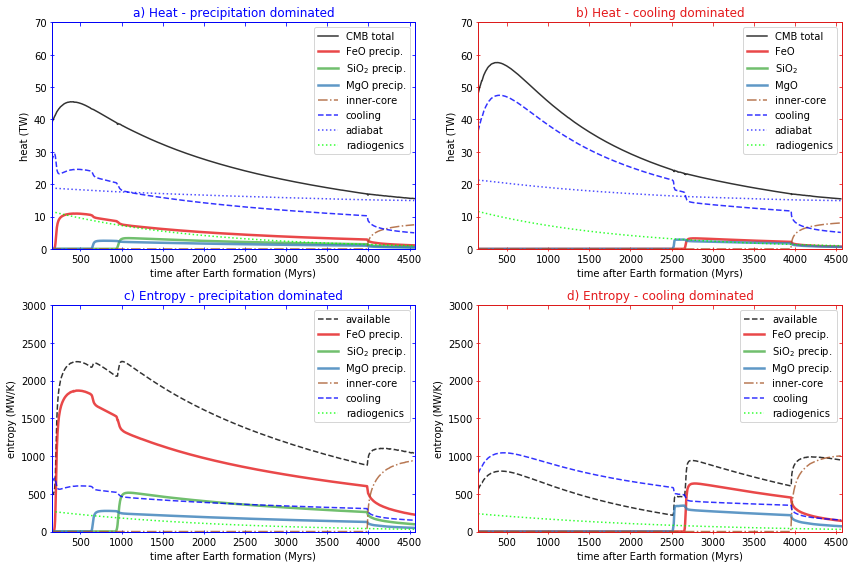

In [34]:

fstyle = '-'
mstyle = '-'
sstyle = '-'
ostyle = '-'

precip_color = 'blue'
cool_color = '#e41a1c'
fcolor = '#e41a1c'
fscolor = '#ff7f00'
mcolor = '#377eb8'
mscolor = '#984ea3'
scolor = '#4daf4a'
ocolor = '#ffff99'
iccolor = '#a65628'

# precip_color = '#fbb4ae' # red-ish
# fscolor = '#fed9a6' # orange-ish
# mcolor = '#b3cde3' # blue-ish
# mscolor = '#decbe4' # purple-ish?
# scolor = '#ccebc5' # green-ish
# ocolor = '#ffffcc' # yellow?
# iccolor = '#e5d8bd' # 

exlw = 2.5
Cq = 1e12
CE = 1e6
Emax = 3000
Qmax = 70
Myrs = 365.25*3600*24*1e6
xmin = 150*365.25*3600*24*1e6/Myrs
xmax = 4568*365.25*3600*24*1e6/Myrs
alpha = 0.8
fillalpha = 0.5


plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1]) 


foldername = foldername_ex
pl,times,solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
t_plt, allp = dill.load(open(basedir+foldername+alldatafile,'rb'))
Qfe = remove_outliers(t_plt, allp.Qgf + allp.Qlf)
Qmg = remove_outliers(t_plt, allp.Qgm + allp.Qlm)
Qsi = remove_outliers(t_plt, allp.Qgs + allp.Qls)
Qcmb =remove_outliers(t_plt,  allp.Qcmb)
Qk = remove_outliers(t_plt, allp.Qk)
Qs = remove_outliers(t_plt, allp.Qs)
Qic = remove_outliers(t_plt, allp.Qg + allp.Ql)
Qrc = remove_outliers(t_plt, allp.Qrc)

ax = plt.subplot(gs[0])
plt.title('a) Heat - precipitation dominated', color=precip_color)

plt.plot(Qcmb[0]/Myrs, Qcmb[1]/Cq, 'black', alpha=alpha, label=r'CMB total')
plt.plot(Qfe[0]/Myrs, Qfe[1]/Cq, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Qsi[0]/Myrs, Qsi[1]/Cq, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Qmg[0]/Myrs, Qmg[1]/Cq, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Qic[0]/Myrs, Qic[1]/Cq, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Qs[0]/Myrs, Qs[1]/Cq, '--', color='blue', alpha=alpha, label='cooling')
plt.plot(Qk[0]/Myrs, Qk[1]/Cq, ':', color='blue', alpha=0.7, label='adiabat')
plt.plot(Qrc[0]/Myrs, Qrc[1]/Cq, ':', color='lime', alpha=alpha, label='radiogenics')

plt.legend()

plt.ylim(0,Qmax)
plt.xlim(xmin,xmax)
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())
axr.tick_params(color=precip_color)
axt.tick_params(color=precip_color)
ax.tick_params(color=precip_color)
for sp in axr.spines.values():
    sp.set_edgecolor(precip_color)
for sp in axt.spines.values():
    sp.set_edgecolor(precip_color)
ax.set_ylabel('heat (TW)')
ax.set_xlabel('time after Earth formation (Myrs)')


ax = plt.subplot(gs[2])
plt.title('c) Entropy - precipitation dominated', color=precip_color)

Efe = remove_outliers(t_plt, allp.Egf )
Emg = remove_outliers(t_plt, allp.Egm )
Esi = remove_outliers(t_plt, allp.Egs)
Ek = remove_outliers(t_plt, allp.Ek)
Eic = remove_outliers(t_plt, allp.Eg + allp.El)
Es = remove_outliers(t_plt, allp.Es)
Erc = remove_outliers(t_plt, allp.Er)
Ephi = remove_outliers(t_plt, allp.Ephi)
# plt.subplot(gs[0])
plt.plot(Ephi[0]/Myrs, Ephi[1]/CE, '--',color='black', alpha=alpha, label=r'available')
plt.plot(Efe[0]/Myrs, Efe[1]/CE, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Esi[0]/Myrs, Esi[1]/CE, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Emg[0]/Myrs, Emg[1]/CE, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Eic[0]/Myrs, Eic[1]/CE, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Es[0]/Myrs, Es[1]/CE, '--', color='blue', alpha=alpha, label='cooling')
# plt.plot(Ek/CE, '-', color='blue', alpha=0.7, label='adiabat')
plt.plot(Erc[0]/Myrs, Erc[1]/CE, ':', color='lime', alpha=alpha, label='radiogenics')
plt.legend(loc=0)
plt.ylim(0,Emax)
plt.xlim(xmin,xmax)
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())
axr.tick_params(color=precip_color)
axt.tick_params(color=precip_color)
ax.tick_params(color=precip_color)
for sp in axr.spines.values():
    sp.set_edgecolor(precip_color)
for sp in axt.spines.values():
    sp.set_edgecolor(precip_color)
ax.set_ylabel(r'entropy (MW/K)')
ax.set_xlabel('time after Earth formation (Myrs)')



foldername = foldername_c
pl,times,solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
t_plt, allp = dill.load(open(basedir+foldername+alldatafile,'rb'))

Qfe = remove_outliers(t_plt, allp.Qgf + allp.Qlf)
Qmg = remove_outliers(t_plt, allp.Qgm + allp.Qlm)
Qsi = remove_outliers(t_plt, allp.Qgs + allp.Qls)
Qcmb =remove_outliers(t_plt,  allp.Qcmb)
Qk = remove_outliers(t_plt, allp.Qk)
Qs = remove_outliers(t_plt, allp.Qs)
Qic = remove_outliers(t_plt, allp.Qg + allp.Ql)
Qrc = remove_outliers(t_plt, allp.Qrc)

ax = plt.subplot(gs[1])
plt.title('b) Heat - cooling dominated', color=cool_color)


plt.plot(Qcmb[0]/Myrs, Qcmb[1]/Cq, 'black', alpha=alpha, label=r'CMB total')
plt.plot(Qfe[0]/Myrs, Qfe[1]/Cq, fstyle,color=fcolor, alpha=alpha, label=r'FeO', lw=exlw)
plt.plot(Qsi[0]/Myrs, Qsi[1]/Cq, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$', lw=exlw)
plt.plot(Qmg[0]/Myrs, Qmg[1]/Cq, mstyle,color=mcolor, alpha=alpha, label=r'MgO', lw=exlw)
plt.plot(Qic[0]/Myrs, Qic[1]/Cq, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Qs[0]/Myrs, Qs[1]/Cq, '--', color='blue', alpha=alpha, label='cooling')
plt.plot(Qk[0]/Myrs, Qk[1]/Cq, ':', color='blue', alpha=0.7, label='adiabat')
plt.plot(Qrc[0]/Myrs, Qrc[1]/Cq, ':', color='lime', alpha=alpha, label='radiogenics')

plt.legend()

plt.ylim(0,Qmax)
plt.xlim(xmin,xmax)
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())
for sp in axr.spines.values():
    sp.set_edgecolor(cool_color)
for sp in axt.spines.values():
    sp.set_edgecolor(cool_color)
axr.tick_params(color=cool_color)
axt.tick_params(color=cool_color)
ax.tick_params(color=cool_color)
ax.set_ylabel('heat (TW)')
ax.set_xlabel('time after Earth formation (Myrs)')


ax = plt.subplot(gs[3])

plt.title('d) Entropy - cooling dominated', color=cool_color)

CE = 1e6
Efe = remove_outliers(t_plt, allp.Egf )
Emg = remove_outliers(t_plt, allp.Egm )
Esi = remove_outliers(t_plt, allp.Egs)
Ek = remove_outliers(t_plt, allp.Ek)
Eic = remove_outliers(t_plt, allp.Eg + allp.El)
Es = remove_outliers(t_plt, allp.Es)
Erc = remove_outliers(t_plt, allp.Er)
Ephi = remove_outliers(t_plt, allp.Ephi)
# plt.subplot(gs[0])
plt.plot(Ephi[0]/Myrs, Ephi[1]/CE, '--',color='black', alpha=alpha, label=r'available')
plt.plot(Efe[0]/Myrs, Efe[1]/CE, fstyle,color=fcolor, alpha=alpha, label=r'FeO precip.', lw=exlw)
plt.plot(Esi[0]/Myrs, Esi[1]/CE, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$ precip.', lw=exlw)
plt.plot(Emg[0]/Myrs, Emg[1]/CE, mstyle,color=mcolor, alpha=alpha, label=r'MgO precip.', lw=exlw)
plt.plot(Eic[0]/Myrs, Eic[1]/CE, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Es[0]/Myrs, Es[1]/CE, '--', color='blue', alpha=alpha, label='cooling')
# plt.plot(Ek/CE, '-', color='blue', alpha=0.7, label='adiabat')
plt.plot(Erc[0]/Myrs, Erc[1]/CE, ':', color='lime', alpha=alpha, label='radiogenics')
plt.legend(loc=0)
plt.ylim(0,Emax)
plt.xlim(xmin,xmax)
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())
axr.tick_params(color=cool_color)
axt.tick_params(color=cool_color)
ax.tick_params(color=cool_color)

for sp in axr.spines.values():
    sp.set_edgecolor(cool_color)
for sp in axt.spines.values():
    sp.set_edgecolor(cool_color)
ax.set_ylabel(r'entropy (MW/K)')
ax.set_xlabel('time after Earth formation (Myrs)')


plt.tight_layout()
plt.savefig('figure2_rdbu.pdf')

# Plot Old Versions

In [ ]:


foldername = foldername_ex
pl,times,solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
t_plt, allp = dill.load(open(basedir+foldername+alldatafile,'rb'))

In [45]:



fstyle = '-'
mstyle = '-'
sstyle = '-'
ostyle = '-'

fcolor = '#e41a1c'
fscolor = '#ff7f00'
mcolor = '#377eb8'
mscolor = '#984ea3'
scolor = '#4daf4a'
ocolor = '#ffff99'
iccolor = '#a65628'

# fcolor = '#fbb4ae' # red-ish
# fscolor = '#fed9a6' # orange-ish
# mcolor = '#b3cde3' # blue-ish
# mscolor = '#decbe4' # purple-ish?
# scolor = '#ccebc5' # green-ish
# ocolor = '#ffffcc' # yellow?
# iccolor = '#e5d8bd' # 

exlw = 2.5
Cq = 1e12
Myrs = 365.25*3600*24*1e6
xmin = 150*365.25*3600*24*1e6/Myrs
xmax = 4568*365.25*3600*24*1e6/Myrs
alpha = 0.8
fillalpha = 0.5
plt.figure(figsize=(12,8))



gs = gridspec.GridSpec(2, 2, height_ratios=[1,1]) 
Qfe = remove_outliers(t_plt, allp.Qgf + allp.Qlf)
Qmg = remove_outliers(t_plt, allp.Qgm + allp.Qlm)
Qsi = remove_outliers(t_plt, allp.Qgs + allp.Qls)
Qcmb =remove_outliers(t_plt,  allp.Qcmb)
Qk = remove_outliers(t_plt, allp.Qk)
Qs = remove_outliers(t_plt, allp.Qs)
Qic = remove_outliers(t_plt, allp.Qg + allp.Ql)
Qrc = remove_outliers(t_plt, allp.Qrc)

ax = plt.subplot(gs[0])
plt.plot(Qcmb[0]/Myrs, Qcmb[1]/Cq, 'black', alpha=alpha, label=r'CMB total')
plt.plot(Qfe[0]/Myrs, Qfe[1]/Cq, fstyle,color=fcolor, alpha=alpha, label=r'FeO', lw=exlw)
plt.plot(Qsi[0]/Myrs, Qsi[1]/Cq, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$', lw=exlw)
plt.plot(Qmg[0]/Myrs, Qmg[1]/Cq, mstyle,color=mcolor, alpha=alpha, label=r'MgO', lw=exlw)
plt.plot(Qic[0]/Myrs, Qic[1]/Cq, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Qs[0]/Myrs, Qs[1]/Cq, '--', color='blue', alpha=alpha, label='cooling')
plt.plot(Qk[0]/Myrs, Qk[1]/Cq, ':', color='blue', alpha=0.7, label='adiabat')
plt.plot(Qrc[0]/Myrs, Qrc[1]/Cq, ':', color='lime', alpha=alpha, label='radiogenics')

plt.legend()

plt.ylim(0,)
plt.xlim(xmin,xmax)
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())
ax.set_ylabel('heat (TW)')
ax.set_xlabel('time after Earth formation (Myrs)')

plt.title('a) Heat Flow')
# plt.grid()

ax = plt.subplot(gs[1])
CE = 1e6
Efe = remove_outliers(t_plt, allp.Egf )
Emg = remove_outliers(t_plt, allp.Egm )
Esi = remove_outliers(t_plt, allp.Egs)
Ek = remove_outliers(t_plt, allp.Ek)
Eic = remove_outliers(t_plt, allp.Eg + allp.El)
Es = remove_outliers(t_plt, allp.Es)
Erc = remove_outliers(t_plt, allp.Er)
Ephi = remove_outliers(t_plt, allp.Ephi)
# plt.subplot(gs[0])
plt.plot(Ephi[0]/Myrs, Ephi[1]/CE, '--',color='black', alpha=alpha, label=r'available')
plt.plot(Efe[0]/Myrs, Efe[1]/CE, fstyle,color=fcolor, alpha=alpha, label=r'FeO', lw=exlw)
plt.plot(Esi[0]/Myrs, Esi[1]/CE, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$', lw=exlw)
plt.plot(Emg[0]/Myrs, Emg[1]/CE, mstyle,color=mcolor, alpha=alpha, label=r'MgO', lw=exlw)
plt.plot(Eic[0]/Myrs, Eic[1]/CE, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(Es[0]/Myrs, Es[1]/CE, '--', color='blue', alpha=alpha, label='cooling')
# plt.plot(Ek/CE, '-', color='blue', alpha=0.7, label='adiabat')
plt.plot(Erc[0]/Myrs, Erc[1]/CE, ':', color='lime', alpha=alpha, label='radiogenics')
plt.legend(loc=0)
plt.ylim(0,)
plt.xlim(xmin,xmax)
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

ax.set_ylabel(r'entropy (MW/K)')
ax.set_xlabel('time after Earth formation (Myrs)')

plt.title('b) Entropy')
# plt.grid()


# ax = plt.subplot(gs[2])
N_approx = 1000
di = int((len(times) - 1) // N_approx)

tm_plt = times[::di]/Myrs
N = len(tm_plt)
M_c, M_m = pl.reactions.unwrap_Moles(solution[::di, 2:][:N,:], return_sum=True, split_coremantle=True)
wt_mmass = np.expand_dims(np.array(pl.reactions.mantle.molmass),1)
wt = np.array(M_m)[:-1,:]*wt_mmass
wt_M_m =wt/np.sum(wt,0)
del wt_mmass,wt
wt_mmass = np.expand_dims(np.array(pl.reactions.core.molmass),1)
wt = np.array(M_c)[:-1,:]*wt_mmass
wt_M_c = wt/np.sum(wt,0)

names_c = pl.params.reactions.core.species
names_c.append('core')
colors_c = [mcolor, scolor, fcolor, ocolor]
names_m = pl.params.reactions.mantle.species
colorsc_m = [mcolor,scolor,fcolor,mscolor,fscolor]
names_m.append('mantle')


# plt.title('c) Core Composition')
# M0 = np.zeros(N)
# for i in [0, 1, 3, 2]:
#     if i != 0:
#         M0 = M1
#     M1 = M0 + wt_M_c[i]
#     plt.fill_between(100-M0*100., 100-M1*100., label=names_c[i], facecolor=colors_c[i], alpha=fillalpha, lw=0.5, edgecolor='k')
# #     plt.plot(100-M1*100., color='k',lw=0.5)
# plt.legend(loc='lower right')
# plt.ylim(90, 100)
# plt.xlim(xmin,xmax)
# axt = ax.twiny()
# axr = ax.twinx()
# ax.tick_params()
# ax.tick_params(bottom=True, left=True, direction='inout')
# axt.tick_params(top=True, direction='in')
# axr.tick_params(right=True, direction='in')
# axt.set_xticklabels([])
# axt.set_xticks(ax.get_xticks())
# axt.set_xlim(ax.get_xlim())
# axr.set_yticklabels([])
# axr.set_ylim(ax.get_ylim())
# axr.set_yticks(ax.get_yticks())

# ax.set_ylabel('wt %')
# ax.set_xlabel('time after Earth formation (Myrs)')
# plt.grid()


ax = plt.subplot(gs[3])
plt.title('d) Interaction Layer Composition')
M0 = np.zeros(N)
# for i in [0, 1, 2, 3, 4]:
for i in [4,3,2,0,1]:
    if i != 4:
        M0 = M1
    M1 = M0 + wt_M_m[i]
    plt.fill_between(tm_plt, 100-M0*100., 100-M1*100., label=names_m[i], facecolor=colorsc_m[i], alpha=fillalpha, lw=0.5, edgecolor='k')
#     plt.plot(100-M1*100., color='k',lw=0.5)

plt.legend(loc='upper left')
plt.ylim(0, 100)
plt.xlim(xmin,xmax)
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

ax.set_ylabel('wt %')
ax.set_xlabel('time after Earth formation (Myrs)')
# plt.grid()
plt.tight_layout()
plt.savefig('figure2_new_l6000K.pdf')

# Old Plots

/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/nknezek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


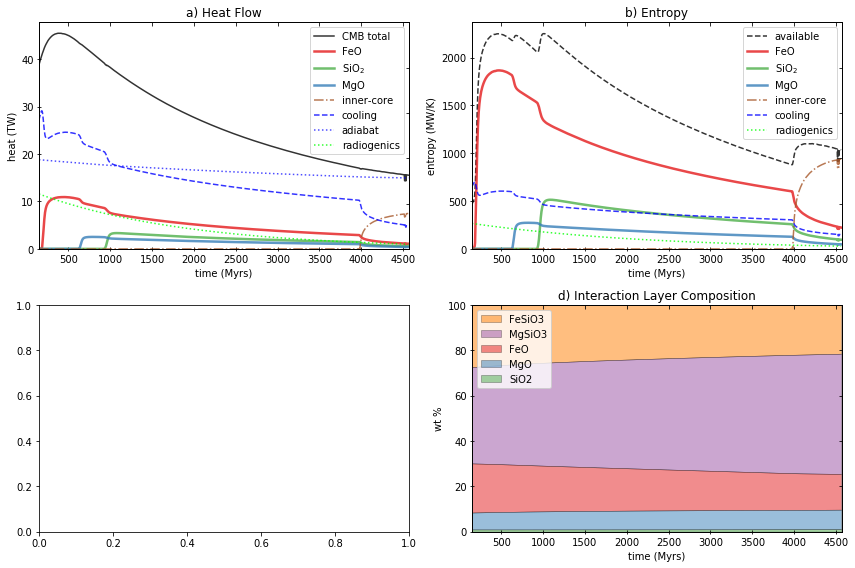

In [27]:
fstyle = '-'
mstyle = '-'
sstyle = '-'
ostyle = '-'

fcolor = '#e41a1c'
fscolor = '#ff7f00'
mcolor = '#377eb8'
mscolor = '#984ea3'
scolor = '#4daf4a'
ocolor = '#ffff99'
iccolor = '#a65628'

# fcolor = '#fbb4ae' # red-ish
# fscolor = '#fed9a6' # orange-ish
# mcolor = '#b3cde3' # blue-ish
# mscolor = '#decbe4' # purple-ish?
# scolor = '#ccebc5' # green-ish
# ocolor = '#ffffcc' # yellow?
# iccolor = '#e5d8bd' # 

exlw = 2.5
Cq = 1e12
Myrs = 365.25*3600*24*1e6
xmin = 150*365.25*3600*24*1e6/Myrs
xmax = 4568*365.25*3600*24*1e6/Myrs
alpha = 0.8
fillalpha = 0.5
plt.figure(figsize=(12,8))

gs = gridspec.GridSpec(2, 2, height_ratios=[1,1]) 
Qfe = replace_outliers(allp.Qgf + allp.Qlf)
Qmg = replace_outliers(allp.Qgm + allp.Qlm)
Qsi = replace_outliers(allp.Qgs + allp.Qls)
Qcmb =replace_outliers( allp.Qcmb)
Qk = replace_outliers(allp.Qk)
Qs = replace_outliers(allp.Qs)
Qic = replace_outliers(allp.Qg + allp.Ql)
Qrc = replace_outliers(allp.Qrc)

ax = plt.subplot(gs[0])
plt.plot(t_plt/Myrs, Qcmb/Cq, 'black', alpha=alpha, label=r'CMB total')
plt.plot(t_plt/Myrs, Qfe/Cq, fstyle,color=fcolor, alpha=alpha, label=r'FeO', lw=exlw)
plt.plot(t_plt/Myrs, Qsi/Cq, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$', lw=exlw)
plt.plot(t_plt/Myrs, Qmg/Cq, mstyle,color=mcolor, alpha=alpha, label=r'MgO', lw=exlw)
plt.plot(t_plt/Myrs, Qic/Cq, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(t_plt/Myrs, Qs/Cq, '--', color='blue', alpha=alpha, label='cooling')
plt.plot(t_plt/Myrs, Qk/Cq, ':', color='blue', alpha=0.7, label='adiabat')
plt.plot(t_plt/Myrs, Qrc/Cq, ':', color='lime', alpha=alpha, label='radiogenics')

plt.legend()

plt.ylim(0,)
plt.xlim(xmin,xmax)
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())
ax.set_ylabel('heat (TW)')
ax.set_xlabel('time (Myrs)')

plt.title('a) Heat Flow')
# plt.grid()

ax = plt.subplot(gs[1])
CE = 1e6
Efe = replace_outliers(allp.Egf )
Emg = replace_outliers(allp.Egm )
Esi = replace_outliers(allp.Egs)
Ek = replace_outliers(allp.Ek)
Eic = replace_outliers(allp.Eg + allp.El)
Es = replace_outliers(allp.Es)
Erc = replace_outliers(allp.Er)
Ephi = replace_outliers(allp.Ephi)
# plt.subplot(gs[0])
plt.plot(t_plt/Myrs, Ephi/CE, '--',color='black', alpha=alpha, label=r'available')
plt.plot(t_plt/Myrs, Efe/CE, fstyle,color=fcolor, alpha=alpha, label=r'FeO', lw=exlw)
plt.plot(t_plt/Myrs, Esi/CE, sstyle, color=scolor, alpha=alpha, label=r'SiO$_2$', lw=exlw)
plt.plot(t_plt/Myrs, Emg/CE, mstyle,color=mcolor, alpha=alpha, label=r'MgO', lw=exlw)
plt.plot(t_plt/Myrs, Eic/CE, '-.', color=iccolor, alpha=alpha, label='inner-core')
plt.plot(t_plt/Myrs, Es/CE, '--', color='blue', alpha=alpha, label='cooling')
# plt.plot(t_plt/Myrs, Ek/CE, '-', color='blue', alpha=0.7, label='adiabat')
plt.plot(t_plt/Myrs, Erc/CE, ':', color='lime', alpha=alpha, label='radiogenics')
plt.legend(loc=0)
plt.ylim(0,)
plt.xlim(xmin,xmax)
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

ax.set_ylabel(r'entropy (MW/K)')
ax.set_xlabel('time (Myrs)')

plt.title('b) Entropy')
# plt.grid()


ax = plt.subplot(gs[2])
N_approx = 1000
di = int((len(times) - 1) // N_approx)

N = len(t_plt)
M_c, M_m = pl.reactions.unwrap_Moles(solution[::di, 2:][:N,:], return_sum=True, split_coremantle=True)
wt_mmass = np.expand_dims(np.array(pl.reactions.mantle.molmass),1)
wt = np.array(M_m)[:-1,:]*wt_mmass
wt_M_m =wt/np.sum(wt,0)
del wt_mmass,wt
wt_mmass = np.expand_dims(np.array(pl.reactions.core.molmass),1)
wt = np.array(M_c)[:-1,:]*wt_mmass
wt_M_c = wt/np.sum(wt,0)

names_c = pl.params.reactions.core.species
names_c.append('core')
colors_c = [mcolor, scolor, fcolor, ocolor]
names_m = pl.params.reactions.mantle.species
colorsc_m = [mcolor,scolor,fcolor,mscolor,fscolor]
names_m.append('mantle')


# plt.title('c) Core Composition')
# M0 = np.zeros(N)
# for i in [0, 1, 3, 2]:
#     if i != 0:
#         M0 = M1
#     M1 = M0 + wt_M_c[i]
#     plt.fill_between(t_plt/Myrs, 100-M0*100., 100-M1*100., label=names_c[i], facecolor=colors_c[i], alpha=fillalpha, lw=0.5, edgecolor='k')
# #     plt.plot(t_plt/Myrs, 100-M1*100., color='k',lw=0.5)
# plt.legend(loc='lower right')
# plt.ylim(90, 100)
# plt.xlim(xmin,xmax)
# axt = ax.twiny()
# axr = ax.twinx()
# ax.tick_params()
# ax.tick_params(bottom=True, left=True, direction='inout')
# axt.tick_params(top=True, direction='in')
# axr.tick_params(right=True, direction='in')
# axt.set_xticklabels([])
# axt.set_xticks(ax.get_xticks())
# axt.set_xlim(ax.get_xlim())
# axr.set_yticklabels([])
# axr.set_ylim(ax.get_ylim())
# axr.set_yticks(ax.get_yticks())

# ax.set_ylabel('wt %')
# ax.set_xlabel('time (Myrs)')
# plt.grid()


ax = plt.subplot(gs[3])
plt.title('d) Interaction Layer Composition')
M0 = np.zeros(N)
# for i in [0, 1, 2, 3, 4]:
for i in [4,3,2,0,1]:
    if i != 4:
        M0 = M1
    M1 = M0 + wt_M_m[i]
    plt.fill_between(t_plt/Myrs, 100-M0*100., 100-M1*100., label=names_m[i], facecolor=colorsc_m[i], alpha=fillalpha, lw=0.5, edgecolor='k')
#     plt.plot(t_plt/Myrs, 100-M1*100., color='k',lw=0.5)

plt.legend(loc='upper left')
plt.ylim(0, 100)
plt.xlim(xmin,xmax)
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

ax.set_ylabel('wt %')
ax.set_xlabel('time (Myrs)')
# plt.grid()
plt.tight_layout()
plt.savefig('figure2_new_l6000K.pdf')